# Курсовая работа по машинному обучению
## Датасет: [Semantic Drone Dataset](https://drive.google.com/drive/folders/1N_aUXg2RaD-GkW_DB3tl3TL7hsUN1Xto)
### Выполнил Сипкин В.Ю. из М8О-114СВ-24

## 1. Описание датасета:

### Семантический набор данных дронов фокусируется на семантическом понимании городских сцен для повышения безопасности полетов и посадок автономных дронов.
### На снимках изображены более 20 домов с высоты птичьего полета, полученные на высоте от 5 до 30 метров над землей. Для получения изображений размером 6000x4000 пикселей (24 Мпикс) использовалась камера высокого разрешения. Обучающий набор содержит 400 общедоступных изображений, а тестовый набор состоит из 200 частных изображений.

## 2. Загрузка датасета:

### Подключаем необходимые импорты

In [100]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import cv2
import albumentations as A
import time
import os
from tqdm import tqdm
from torchsummary import summary
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.decoders.unet.model
import glob
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Подготавим данные для задачи семантической сегментации, разделим их на выборки и визуализируем пример изображения с наложенной маской:

In [25]:
IMAGE_PATH = '/home/vladix35/semantic_drone_dataset/original_images/'
MASK_PATH = '/home/vladix35/semantic_drone_dataset/label_images_semantic/'

In [28]:
def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))


n_classes = 23 
df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [29]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)
print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


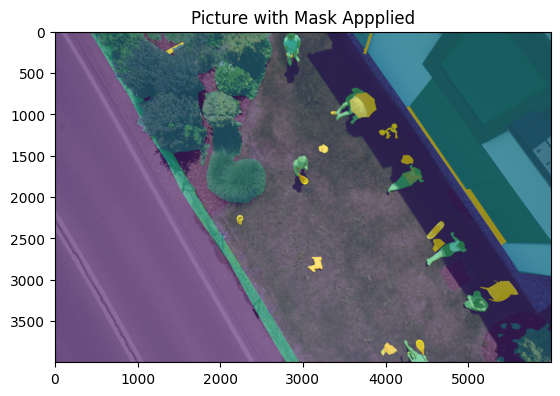

In [30]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

### Загружаем изображения и их маски, применяем аугментацию к данным, а также подготавливаем данные для подачи в модель через DataLoader:

In [31]:
class DroneDataset(Dataset):


    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        

    def __len__(self):
        return len(self.X)
    

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        if self.transform is None:
            img = Image.fromarray(img)
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        if self.patches:
            img, mask = self.tiles(img, mask) 
        return img, mask
    

    def tiles(self, img, mask):
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        return img_patches, mask_patches

In [32]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])
t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)
batch_size= 3 
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)  

## 3. Обучение модели на данном датасете:

### В качестве модели семантической сегментации будем использовать U-Net с предобученным энкодером MobileNetV2:

In [35]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [36]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

### Обучаем нашу модель:

In [37]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [40]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        iou_per_class = []
        for clas in range(0, n_classes):
            true_class = pred_mask == clas
            true_label = mask == clas
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [44]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0
    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            image = image_tiles.to(device); mask = mask_tiles.to(device)
            output = model(image)
            loss = criterion(output, mask)
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            loss.backward()
            optimizer.step()         
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            running_loss += loss.item()
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data
                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()
                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))
            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [45]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

100%|██████████| 18/18 [00:30<00:00,  1.69s/it]


Loss Decreasing.. inf >> 2.388 
Epoch:1/15.. Train Loss: 3.071.. Val Loss: 2.388.. Train mIoU:0.024.. Val mIoU: 0.073.. Train Acc:0.115.. Val Acc:0.365.. Time: 6.33m


100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Loss Decreasing.. 2.388 >> 1.489 
Epoch:2/15.. Train Loss: 2.071.. Val Loss: 1.489.. Train mIoU:0.090.. Val mIoU: 0.117.. Train Acc:0.497.. Val Acc:0.631.. Time: 6.03m


100%|██████████| 18/18 [00:24<00:00,  1.38s/it]


Loss Decreasing.. 1.489 >> 1.411 
Epoch:3/15.. Train Loss: 1.669.. Val Loss: 1.411.. Train mIoU:0.096.. Val mIoU: 0.117.. Train Acc:0.542.. Val Acc:0.627.. Time: 6.09m


100%|██████████| 18/18 [00:25<00:00,  1.41s/it]


Loss Decreasing.. 1.411 >> 1.296 
saving model...
Epoch:4/15.. Train Loss: 1.530.. Val Loss: 1.296.. Train mIoU:0.105.. Val mIoU: 0.122.. Train Acc:0.570.. Val Acc:0.617.. Time: 6.33m


100%|██████████| 18/18 [00:24<00:00,  1.34s/it]


Loss Decreasing.. 1.296 >> 1.178 
Epoch:5/15.. Train Loss: 1.594.. Val Loss: 1.178.. Train mIoU:0.098.. Val mIoU: 0.146.. Train Acc:0.546.. Val Acc:0.669.. Time: 7.48m


100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


Loss Not Decrease for 1 time
Epoch:6/15.. Train Loss: 1.465.. Val Loss: 1.207.. Train mIoU:0.112.. Val mIoU: 0.157.. Train Acc:0.576.. Val Acc:0.657.. Time: 6.07m


100%|██████████| 18/18 [00:26<00:00,  1.47s/it]


Loss Decreasing.. 1.207 >> 1.137 
Epoch:7/15.. Train Loss: 1.389.. Val Loss: 1.137.. Train mIoU:0.134.. Val mIoU: 0.154.. Train Acc:0.603.. Val Acc:0.648.. Time: 6.05m


100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Loss Decreasing.. 1.137 >> 1.058 
Epoch:8/15.. Train Loss: 1.358.. Val Loss: 1.058.. Train mIoU:0.136.. Val mIoU: 0.172.. Train Acc:0.612.. Val Acc:0.699.. Time: 6.15m


100%|██████████| 18/18 [00:25<00:00,  1.41s/it]


Loss Decreasing.. 1.058 >> 1.020 
Epoch:9/15.. Train Loss: 1.347.. Val Loss: 1.020.. Train mIoU:0.133.. Val mIoU: 0.181.. Train Acc:0.608.. Val Acc:0.717.. Time: 6.11m


100%|██████████| 18/18 [00:26<00:00,  1.47s/it]


Loss Decreasing.. 1.020 >> 0.959 
saving model...
Epoch:10/15.. Train Loss: 1.240.. Val Loss: 0.959.. Train mIoU:0.148.. Val mIoU: 0.187.. Train Acc:0.646.. Val Acc:0.718.. Time: 6.38m


100%|██████████| 18/18 [00:28<00:00,  1.58s/it]


Loss Decreasing.. 0.959 >> 0.950 
Epoch:11/15.. Train Loss: 1.188.. Val Loss: 0.950.. Train mIoU:0.154.. Val mIoU: 0.181.. Train Acc:0.657.. Val Acc:0.718.. Time: 6.85m


100%|██████████| 18/18 [00:23<00:00,  1.33s/it]


Loss Decreasing.. 0.950 >> 0.947 
Epoch:12/15.. Train Loss: 1.145.. Val Loss: 0.947.. Train mIoU:0.161.. Val mIoU: 0.173.. Train Acc:0.674.. Val Acc:0.707.. Time: 6.23m


100%|██████████| 18/18 [00:26<00:00,  1.48s/it]


Loss Decreasing.. 0.947 >> 0.940 
Epoch:13/15.. Train Loss: 1.105.. Val Loss: 0.940.. Train mIoU:0.169.. Val mIoU: 0.177.. Train Acc:0.690.. Val Acc:0.707.. Time: 6.08m


100%|██████████| 18/18 [00:25<00:00,  1.42s/it]


Loss Decreasing.. 0.940 >> 0.896 
Epoch:14/15.. Train Loss: 1.015.. Val Loss: 0.896.. Train mIoU:0.179.. Val mIoU: 0.198.. Train Acc:0.711.. Val Acc:0.720.. Time: 6.35m


100%|██████████| 18/18 [00:24<00:00,  1.37s/it]

Loss Decreasing.. 0.896 >> 0.886 
saving model...
Epoch:15/15.. Train Loss: 1.035.. Val Loss: 0.886.. Train mIoU:0.179.. Val mIoU: 0.197.. Train Acc:0.706.. Val Acc:0.722.. Time: 6.39m
Total time: 94.92 m


In [46]:
torch.save(model, 'Unet-Mobilenet.pt')

### Теперь проверим качество модели на тестовом датасете и посмотрим насколько она лучше реализует семантическую сегментацию в зависимости от её степени обучения

In [47]:
class DroneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      

    def __len__(self):
        return len(self.X)
    

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)  
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        if self.transform is None:
            img = Image.fromarray(img)
        mask = torch.from_numpy(mask).long()
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [48]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [49]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [50]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [51]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [52]:
mob_miou = miou_score(model, test_set)

100%|██████████| 40/40 [00:21<00:00,  1.82it/s]


In [53]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [54]:
mob_acc = pixel_acc(model, test_set)

100%|██████████| 40/40 [00:21<00:00,  1.89it/s]


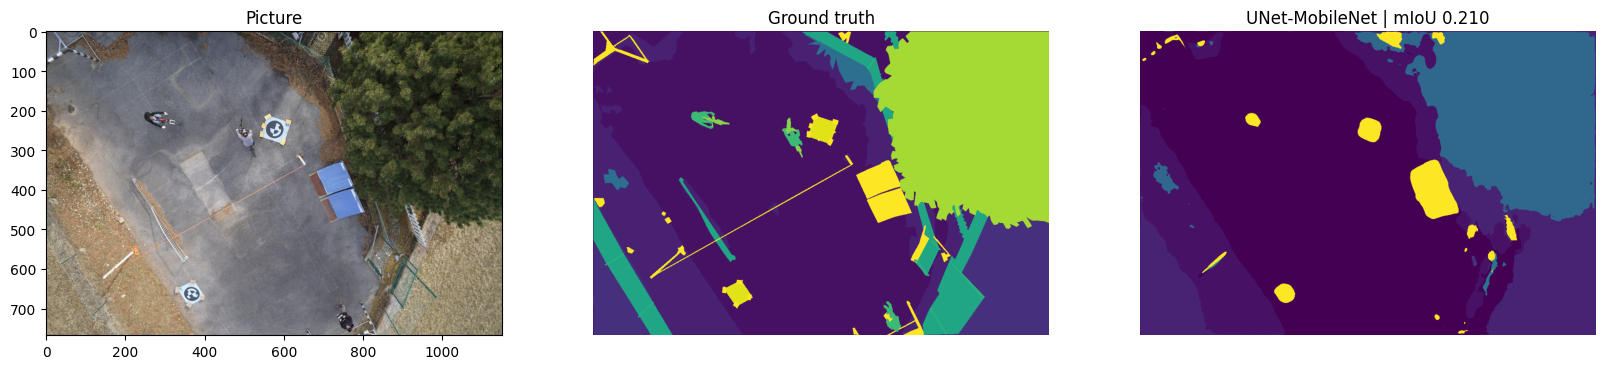

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture')
ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()
ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

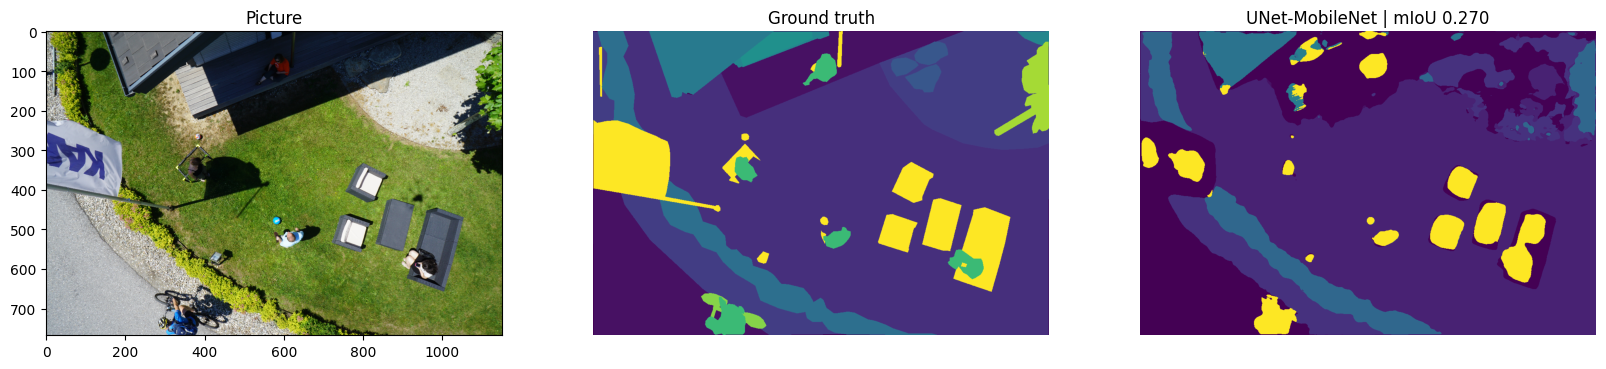

In [59]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture')
ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()
ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

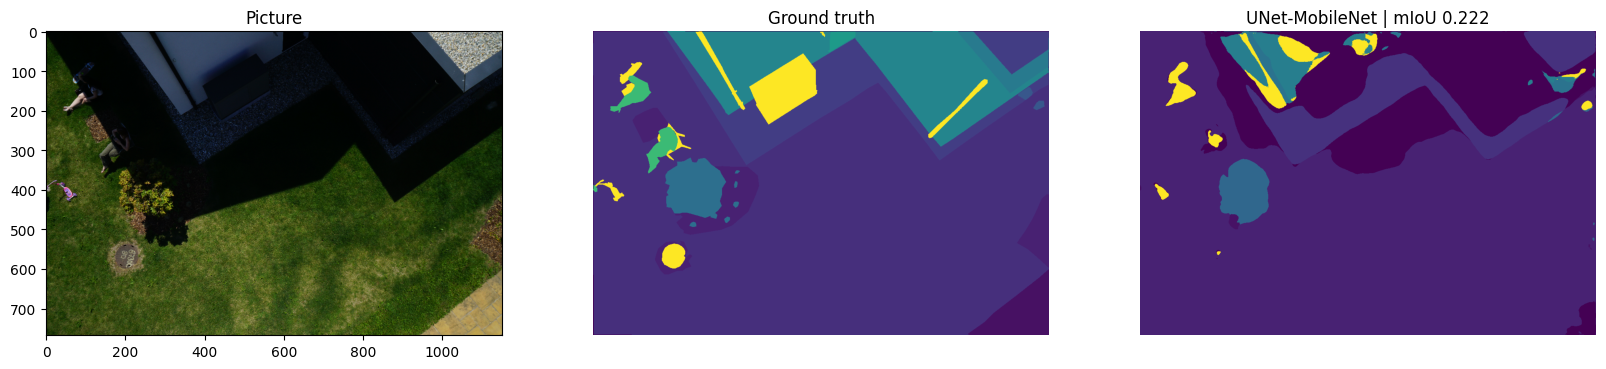

In [58]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture')
ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()
ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

### Теперь реализуем семантическую сегментацию на моих примерах:

In [62]:
IMAGE_DIR       = '/home/vladix35/ML/ML_CourseWork/Img_examples/images'
OUTPUT_MASK_DIR = '/home/vladix35/ML/ML_CourseWork/Img_examples/predicted_masks'
MODEL_PATH      = '/home/vladix35/ML/ML_CourseWork/Unet-Mobilenet.pt'
DEVICE          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

In [72]:
torch.serialization.add_safe_globals([segmentation_models_pytorch.decoders.unet.model.Unet])
model = torch.load(
    MODEL_PATH,
    map_location=DEVICE,
    weights_only=False
)
model.eval().to(DEVICE)
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])


def process_image(img_path, save_dir):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape
    pil = Image.fromarray(img_rgb)
    inp = preprocess(pil).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = model(inp)                          
        pred = torch.argmax(out, dim=1).cpu().squeeze(0).numpy()
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    mask_path = os.path.join(save_dir, base_name + '_pred.png')
    cv2.imwrite(mask_path, pred.astype(np.uint8))
    print(f"Saved: {mask_path}")

In [71]:
for ext in ('*.jpg','*.png'):
    for img_file in glob.glob(os.path.join(IMAGE_DIR, ext)):
        process_image(img_file, OUTPUT_MASK_DIR)

Saved: /home/vladix35/ML/ML_CourseWork/Img_examples/predicted_masks/birdseye-view-house-yard_305343-50244_pred.png
Saved: /home/vladix35/ML/ML_CourseWork/Img_examples/predicted_masks/157652-2024023-26185-ou0n04.hqdu_pred.png
Saved: /home/vladix35/ML/ML_CourseWork/Img_examples/predicted_masks/15427_pred.png
Saved: /home/vladix35/ML/ML_CourseWork/Img_examples/predicted_masks/Semka-dronom-v-Moskve2_pred.png
Saved: /home/vladix35/ML/ML_CourseWork/Img_examples/predicted_masks/b6ff4484dcb415cc4c09cc196afb198c_pred.png


Saved: /home/vladix35/ML/ML_CourseWork/Img_examples/predicted_masks/birdseye-view-house-yard_305343-50244_pred.png


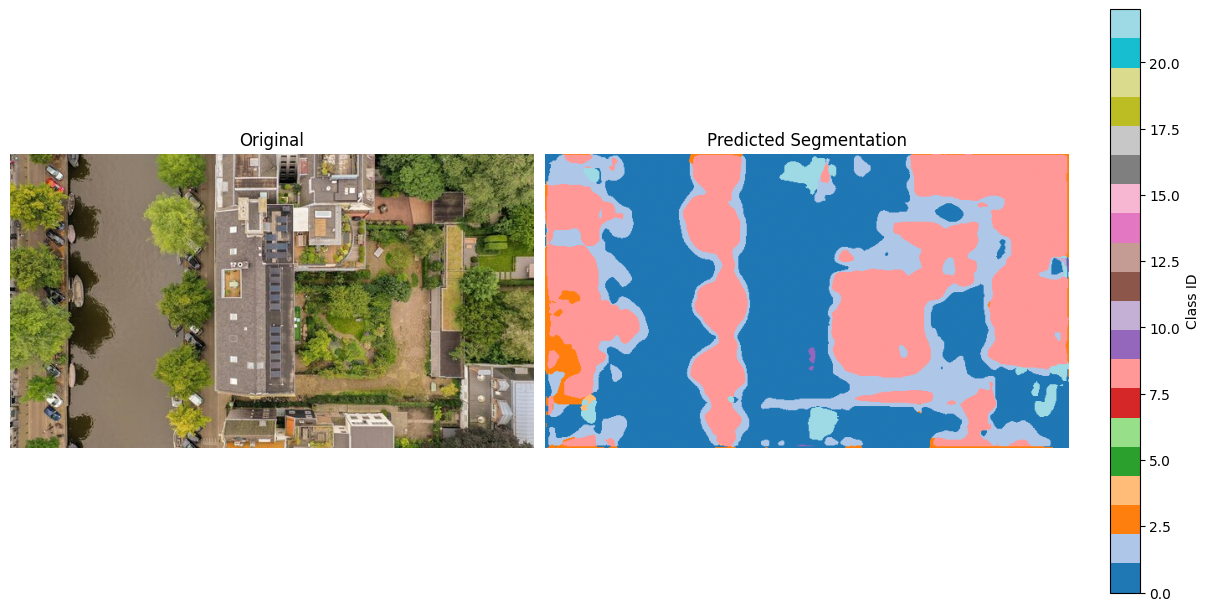

Saved: /home/vladix35/ML/ML_CourseWork/Img_examples/predicted_masks/157652-2024023-26185-ou0n04.hqdu_pred.png


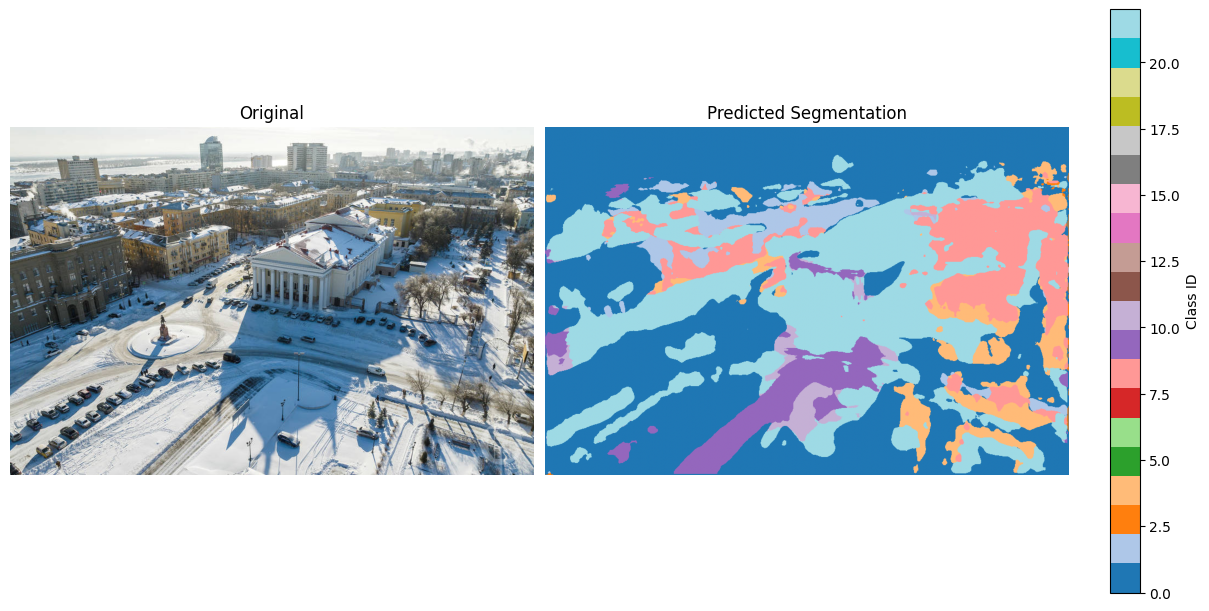

Saved: /home/vladix35/ML/ML_CourseWork/Img_examples/predicted_masks/15427_pred.png


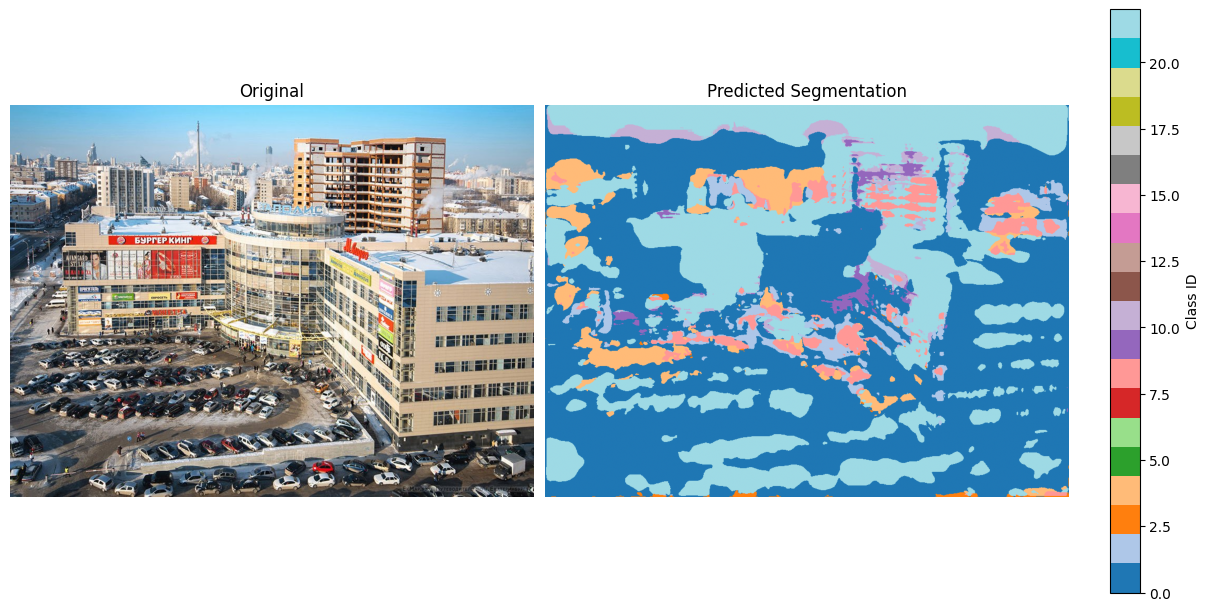

Saved: /home/vladix35/ML/ML_CourseWork/Img_examples/predicted_masks/Semka-dronom-v-Moskve2_pred.png


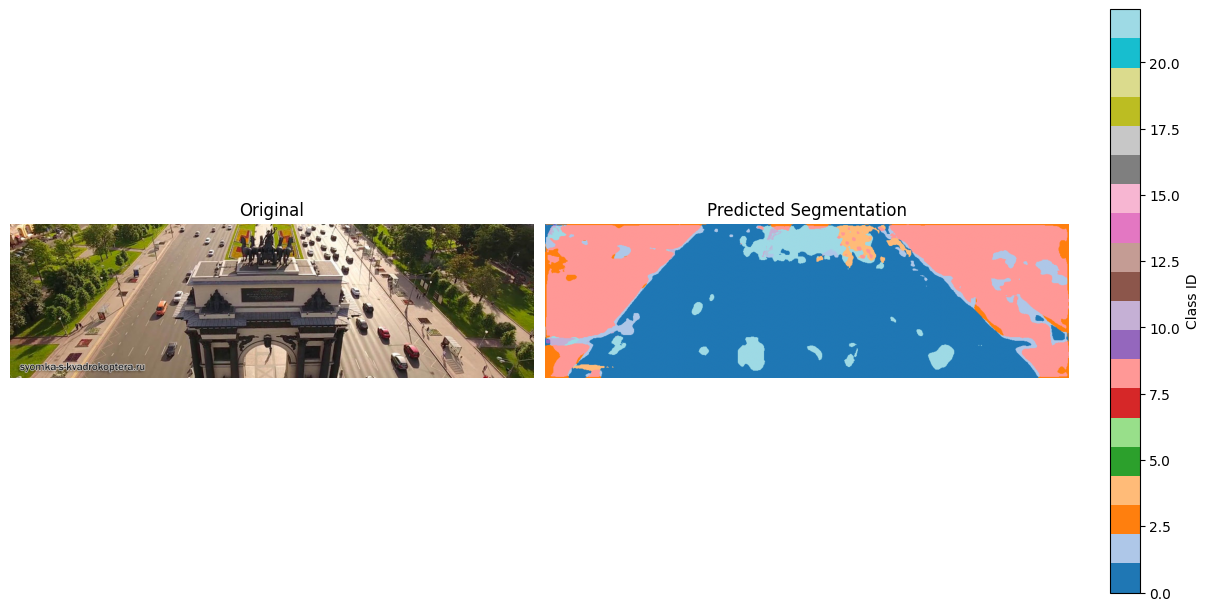

Saved: /home/vladix35/ML/ML_CourseWork/Img_examples/predicted_masks/b6ff4484dcb415cc4c09cc196afb198c_pred.png


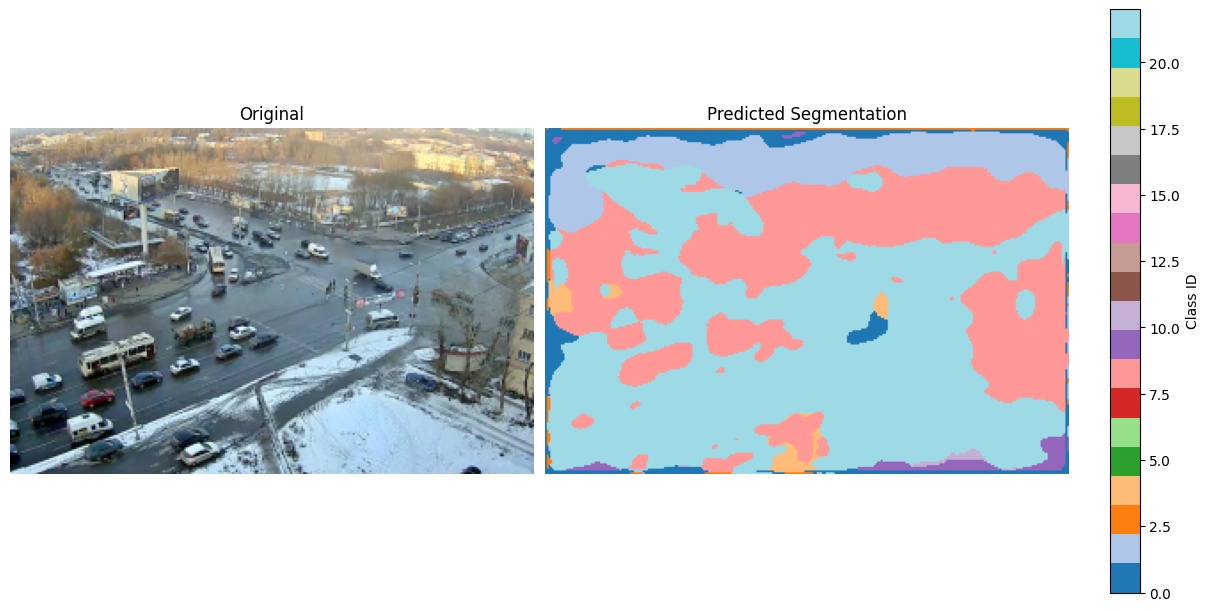

In [78]:
def process_image(img_path, save_dir, visualize=False):
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pil     = Image.fromarray(img_rgb)
    inp = preprocess(pil).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out  = model(inp)
        pred = torch.argmax(out, dim=1).cpu().squeeze(0).numpy()
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    mask_path = os.path.join(save_dir, base_name + '_pred.png')
    cv2.imwrite(mask_path, pred.astype(np.uint8))
    print(f"Saved: {mask_path}")
    if visualize:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
        ax1.imshow(img_rgb)
        ax1.set_title('Original')
        ax1.axis('off')
        im = ax2.imshow(pred, cmap='tab20', vmin=0, vmax=22)
        ax2.set_title('Predicted Segmentation')
        ax2.axis('off')
        cbar = fig.colorbar(im, ax=[ax1, ax2], fraction=0.046, pad=0.04)
        cbar.set_label('Class ID')
        plt.show()

        
for ext in ('*.jpg', '*.png'):
    for img_file in glob.glob(os.path.join(IMAGE_DIR, ext)):
        process_image(img_file, OUTPUT_MASK_DIR, visualize=True)

## Реализуем алгоритм LIME

Применение метода LIME: /home/vladix35/ML/ML_CourseWork/Img_examples/images/birdseye-view-house-yard_305343-50244.jpg


100%|██████████| 1000/1000 [00:27<00:00, 36.68it/s]


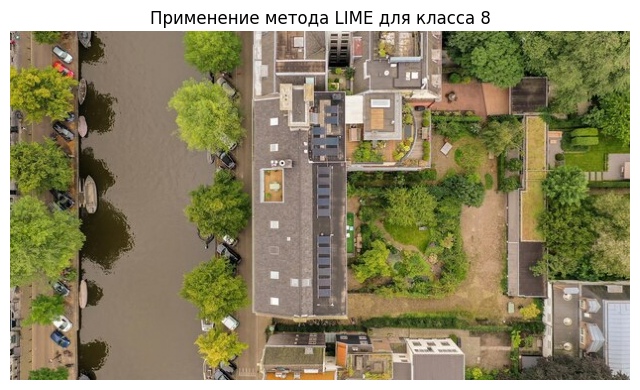

Применение метода LIME: /home/vladix35/ML/ML_CourseWork/Img_examples/images/157652-2024023-26185-ou0n04.hqdu.jpg


100%|██████████| 1000/1000 [01:46<00:00,  9.37it/s]


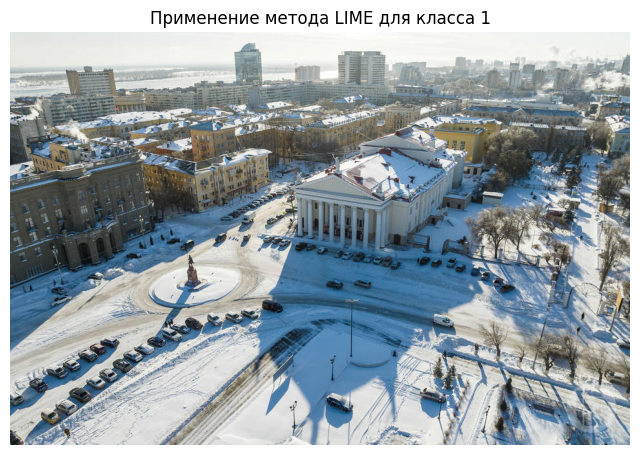

Применение метода LIME: /home/vladix35/ML/ML_CourseWork/Img_examples/images/15427.jpg


100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


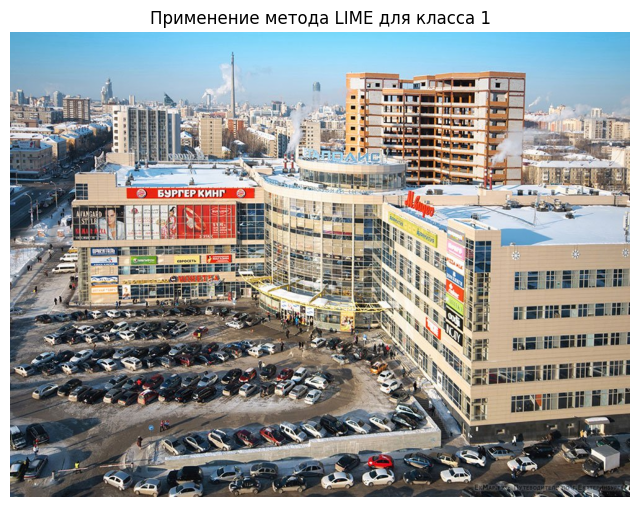

Применение метода LIME: /home/vladix35/ML/ML_CourseWork/Img_examples/images/Semka-dronom-v-Moskve2.jpg


100%|██████████| 1000/1000 [00:29<00:00, 33.78it/s]


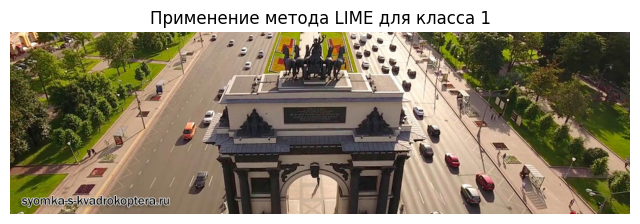

In [102]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def predict_fn(images: np.ndarray) -> np.ndarray:
    model.eval()
    batch_tensors = []
    for img in images:
        pil_img = Image.fromarray(img.astype(np.uint8))
        inp = preprocess(pil_img).unsqueeze(0).to(DEVICE)
        batch_tensors.append(inp)
    batch = torch.cat(batch_tensors, dim=0)
    with torch.no_grad():
        out = model(batch)
        probs = torch.softmax(out, dim=1)
        probs_flat = probs.mean(dim=[2,3]).cpu().numpy()
    return probs_flat


def lime_explain(image_path: str, num_samples: int = 1000):
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image=img_rgb,
        classifier_fn=predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=num_samples
    )
    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        label=top_label,
        positive_only=True,
        hide_rest=False,
        num_features=10,
        min_weight=0.05
    )
    plt.figure(figsize=(8, 8))
    plt.imshow(mark_boundaries(temp.astype(np.uint8), mask))
    plt.title(f'Применение метода LIME для класса {top_label}')
    plt.axis('off')
    plt.show()
for img_file in glob.glob(os.path.join(IMAGE_DIR, '*.jpg')):
    print(f"Применение метода LIME: {img_file}")
    lime_explain(img_file)


# Вывод: было выполнено обучение с помощью U-Net с предобученным энкодером MobileNetV2 на данных датасета Semantic Drone Dataset, проверка предсказания обученной модели на данных датасета и случайных данных, а также примение метода LIME для подсветки пикселей, которые влияют на предсказание